In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

In [2]:
class Random2DLinearRegressionLossSpace(torch.nn.Module):
    def __init__(self, mean, N=10):
        super().__init__()
        self.mean = torch.tensor(mean)
        x = torch.FloatTensor(N).uniform_(-3, 3)
        self.z = torch.stack([x, torch.ones((N, ))])
        self.y = self.project(self.mean)
        
    def project(self, m):
        return torch.nn.functional.softplus(torch.inner(m, self.z.T))
    
    def forward(self, m):
        return ((self.y - self.project(m))**2).sum(axis=-1) / 2

In [3]:
means = [[0.3, 0.05], [0.83, 0.75]]
lossSpaces = [Random2DLinearRegressionLossSpace(m) for m in means]

In [4]:
class Model(torch.nn.Module):
    def __init__(self, loss, resolution=400):
        super().__init__()
        
        X, Y = torch.linspace(0,1, resolution), torch.linspace(0, 1, resolution)
        grid = torch.stack(torch.meshgrid(X, Y), -1)
        
        self.params = torch.nn.parameter.Parameter(grid)
        self.loss = loss
        
    def forward(self):
        return self.loss(self.params)

In [5]:
def visualize_values(ax, values):
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    ax.contourf(values, cmap='viridis', levels=20)
    ax.contour(values, levels=20, colors="w", alpha=0.3)

def save_viz(path, values):
    fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True)
    visualize_values(ax, values)
    fig.savefig(path, bbox_inches='tight', transparent="True", pad_inches=0)

<ipython-input-5-6118555471bb>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True)


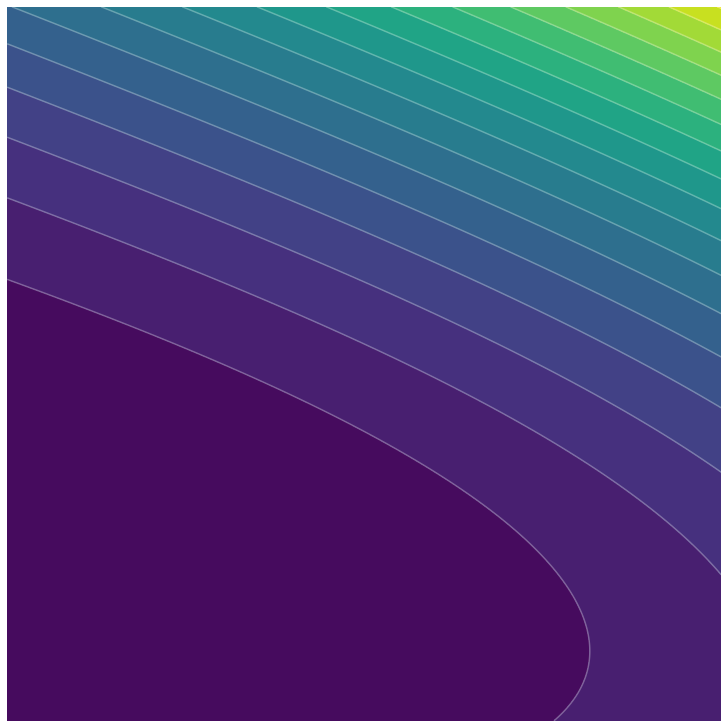

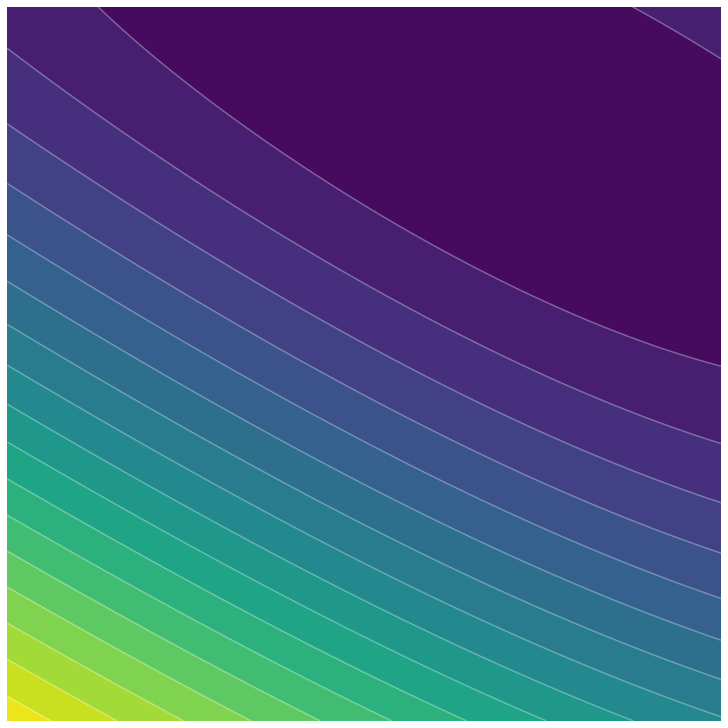

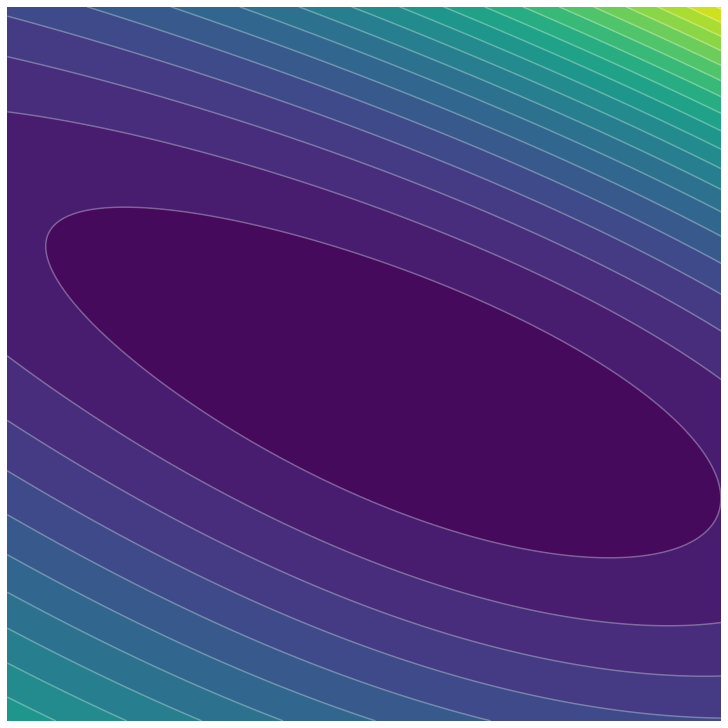

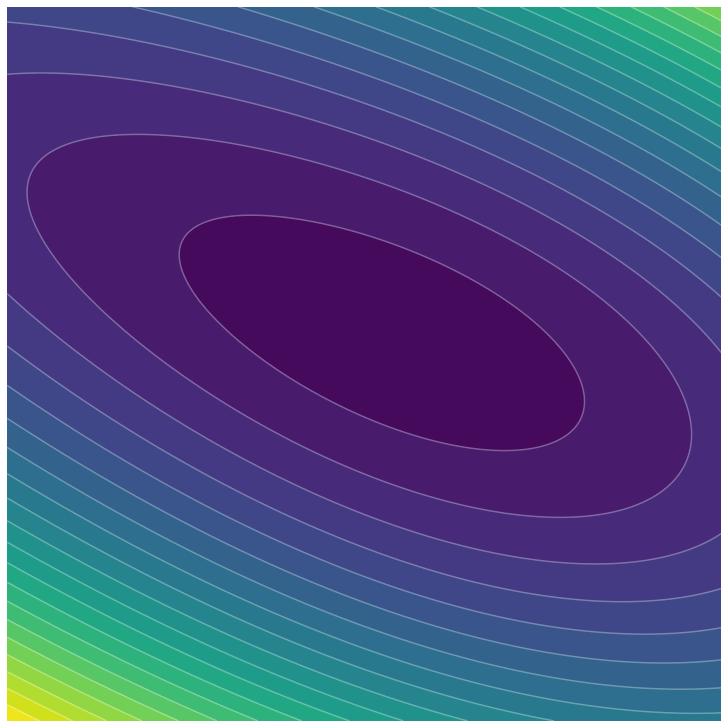

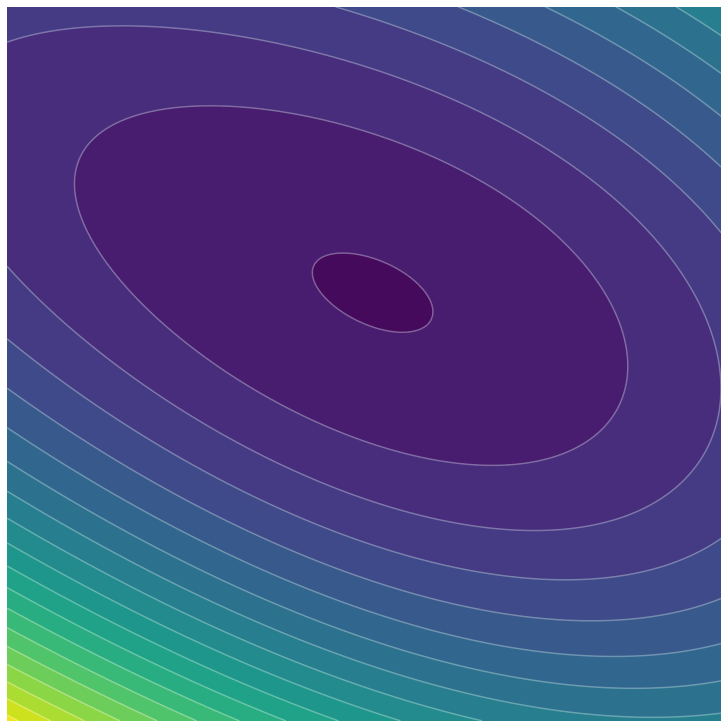

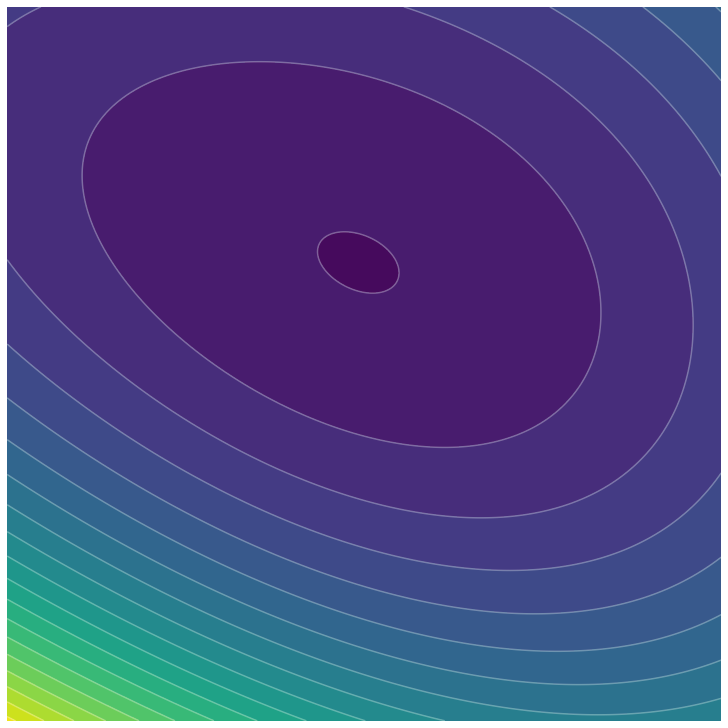

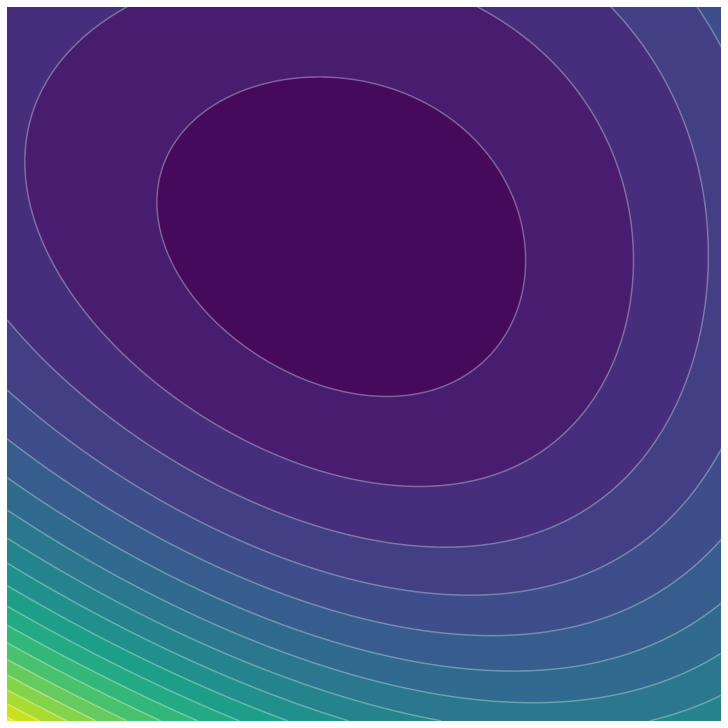

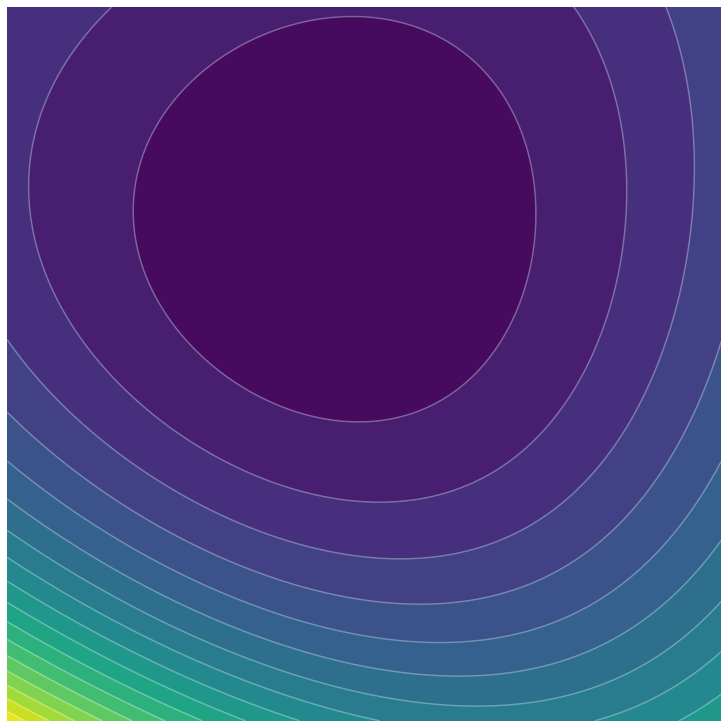

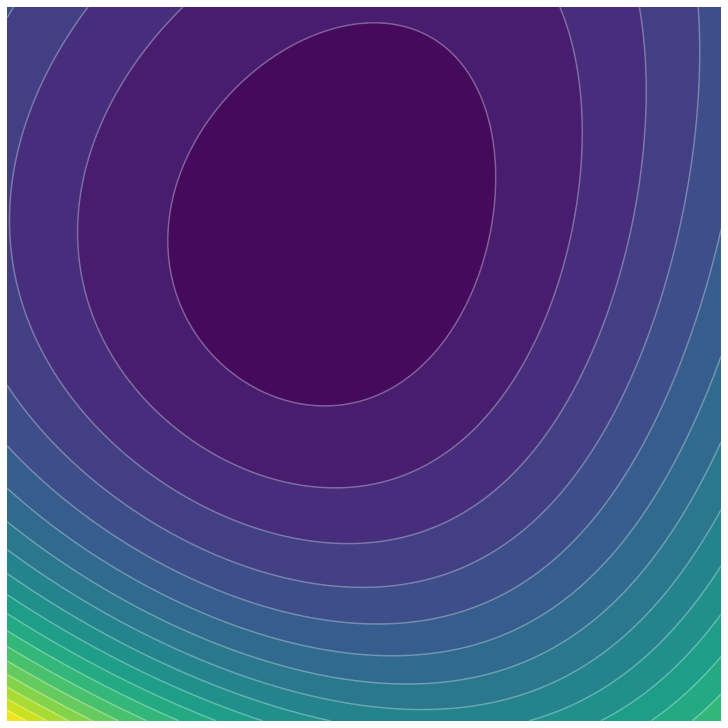

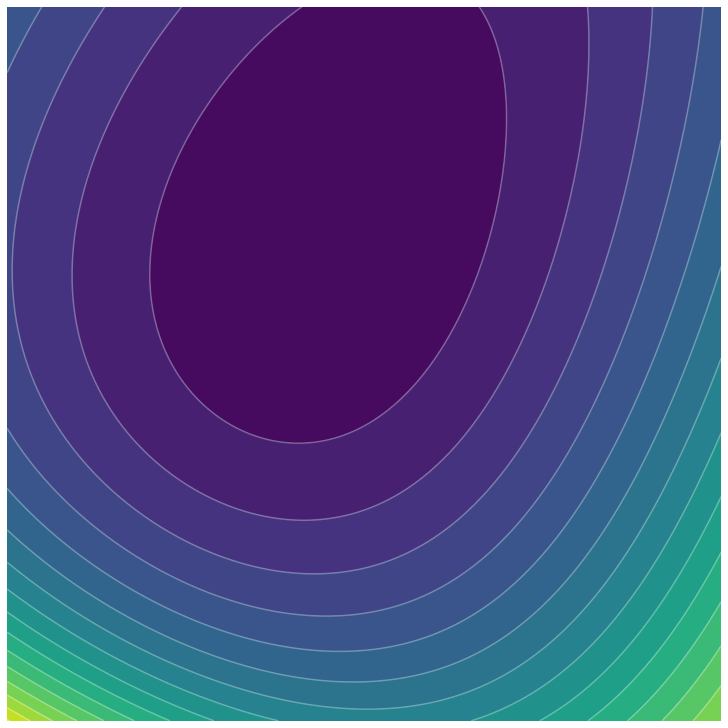

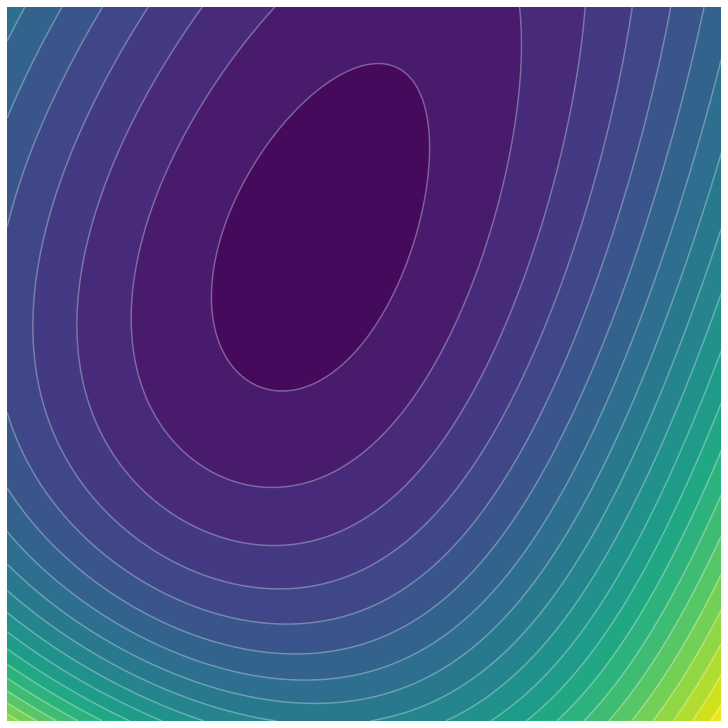

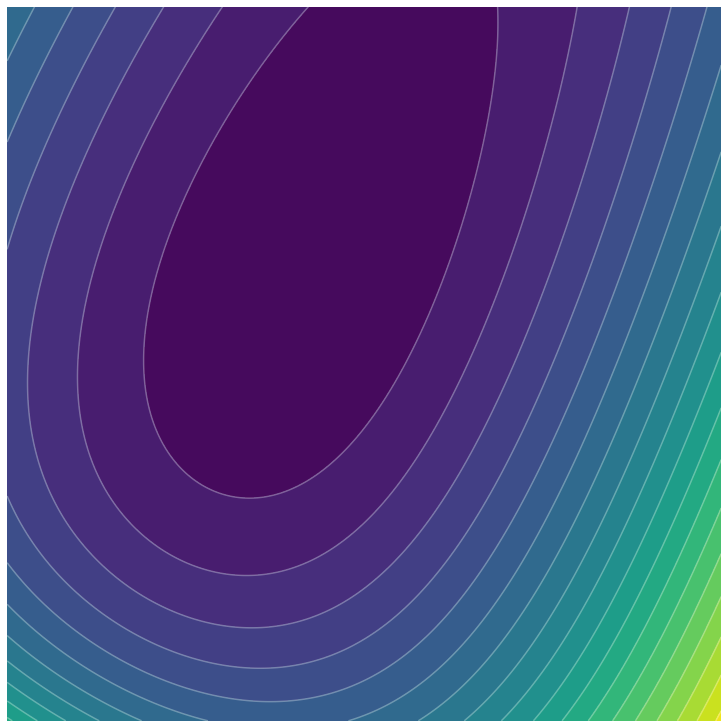

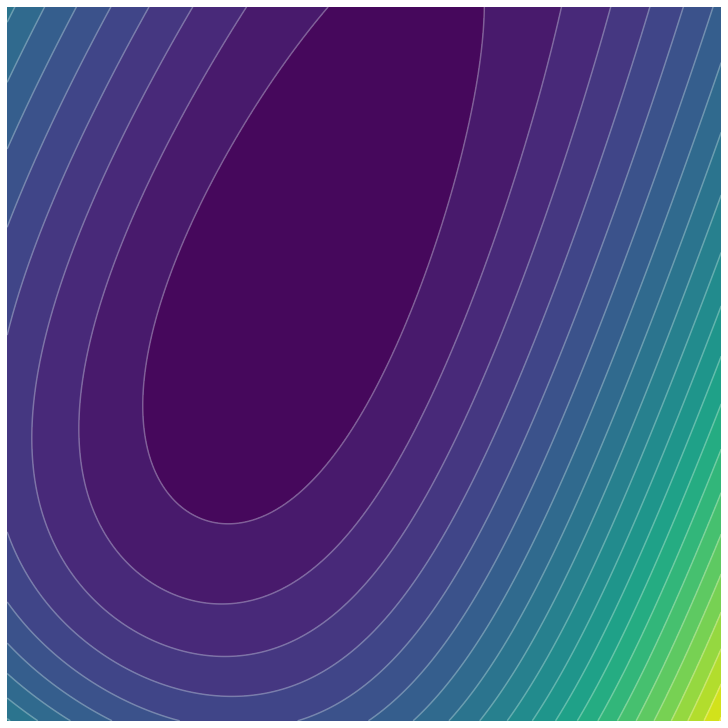

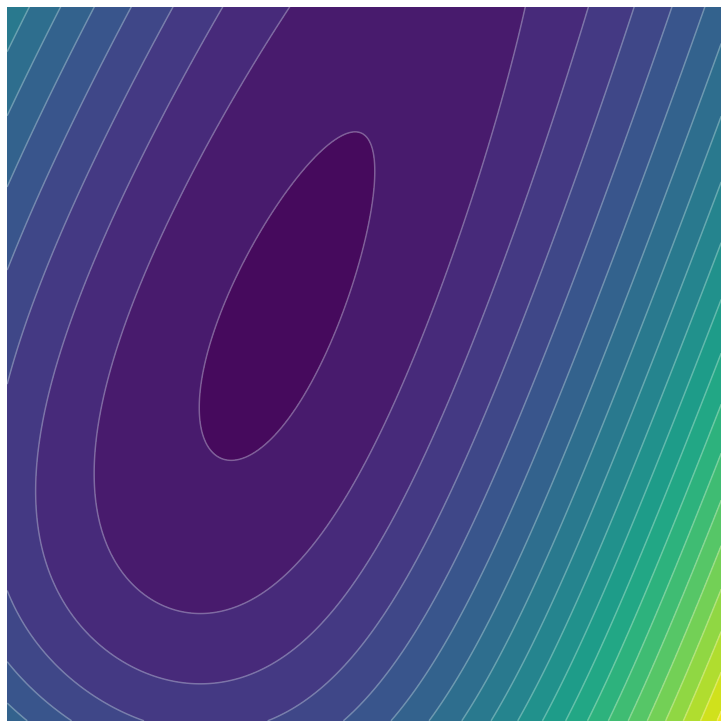

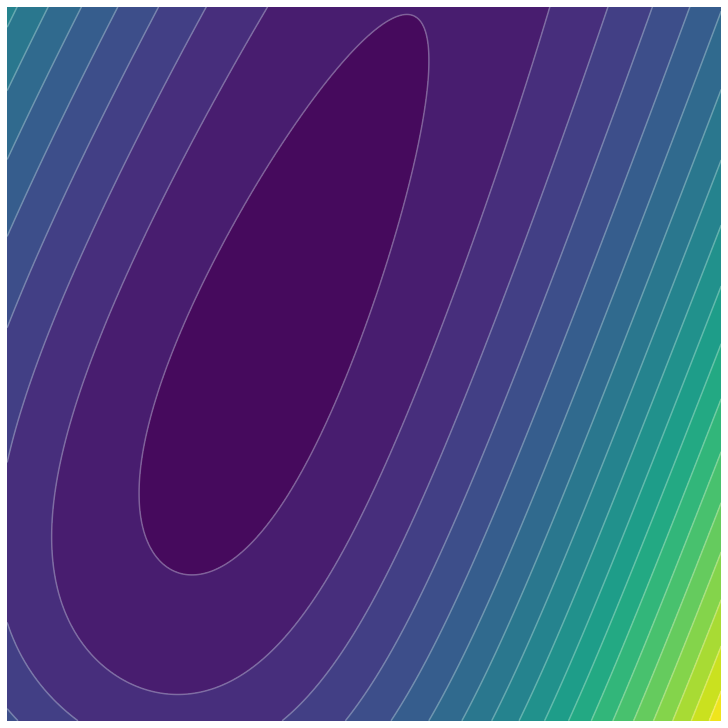

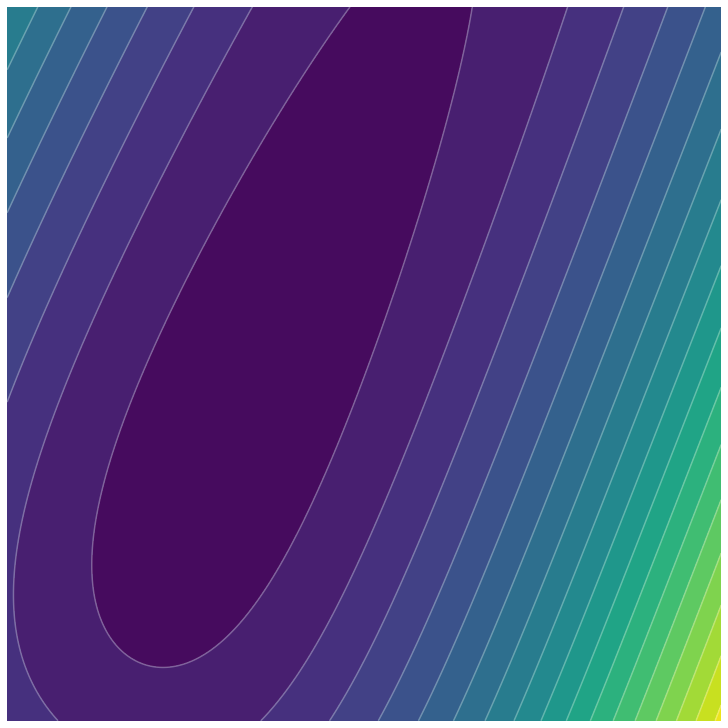

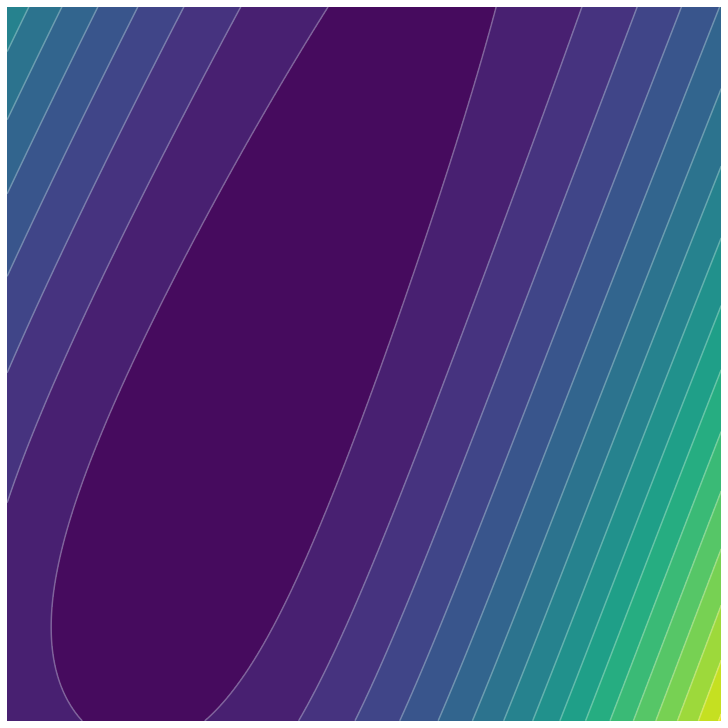

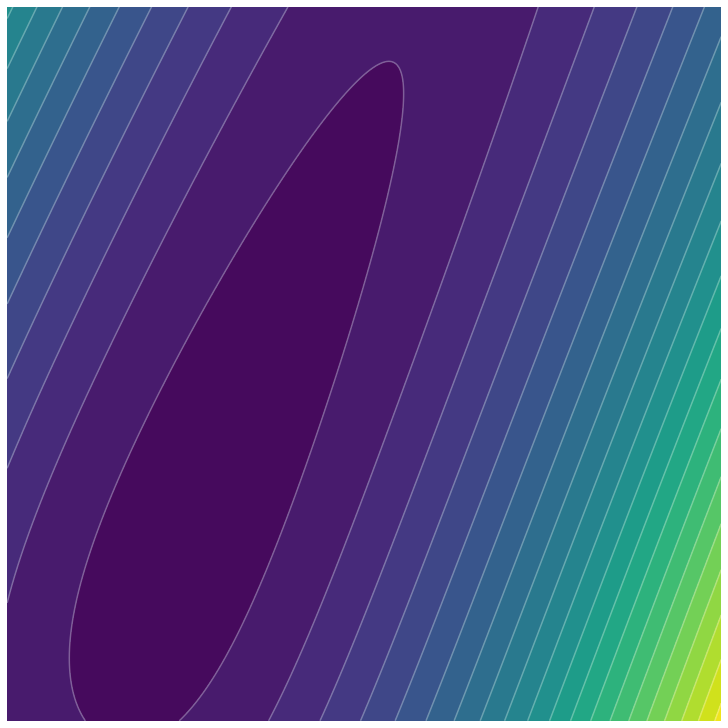

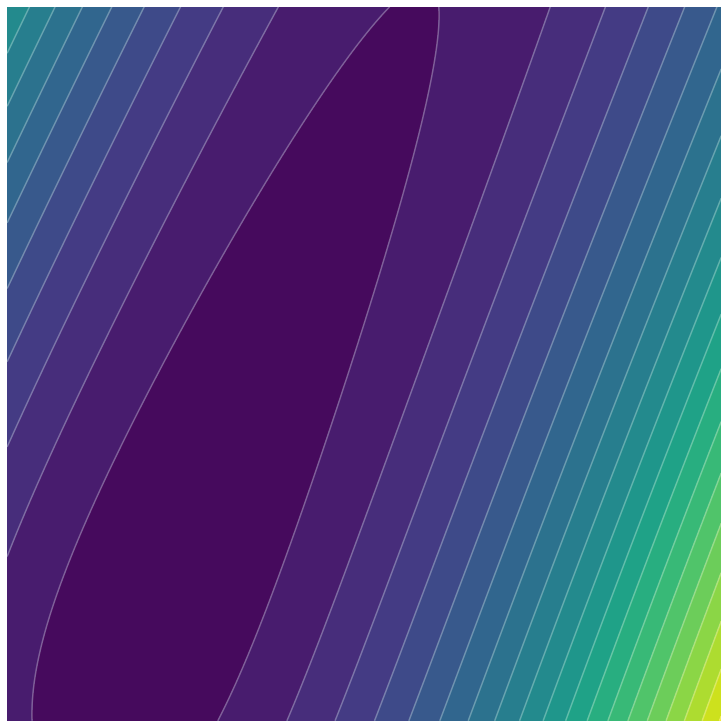

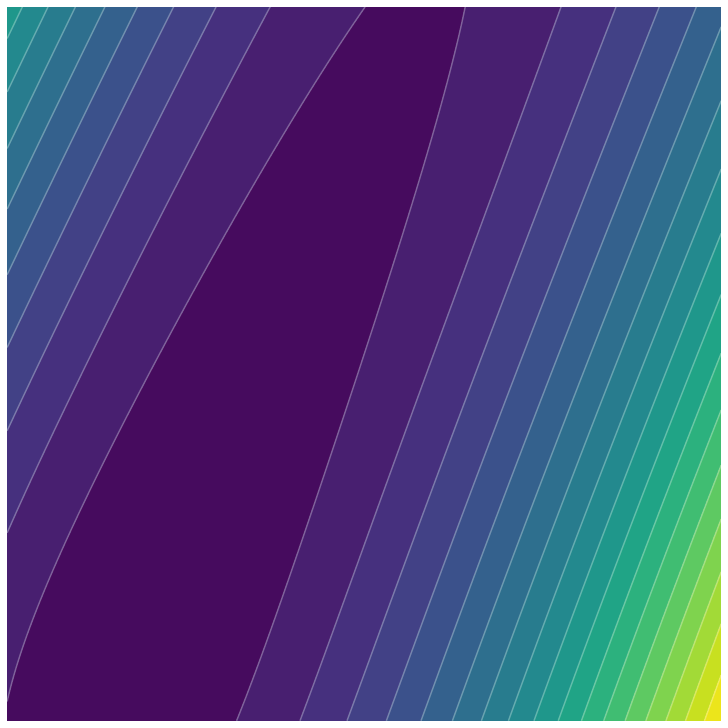

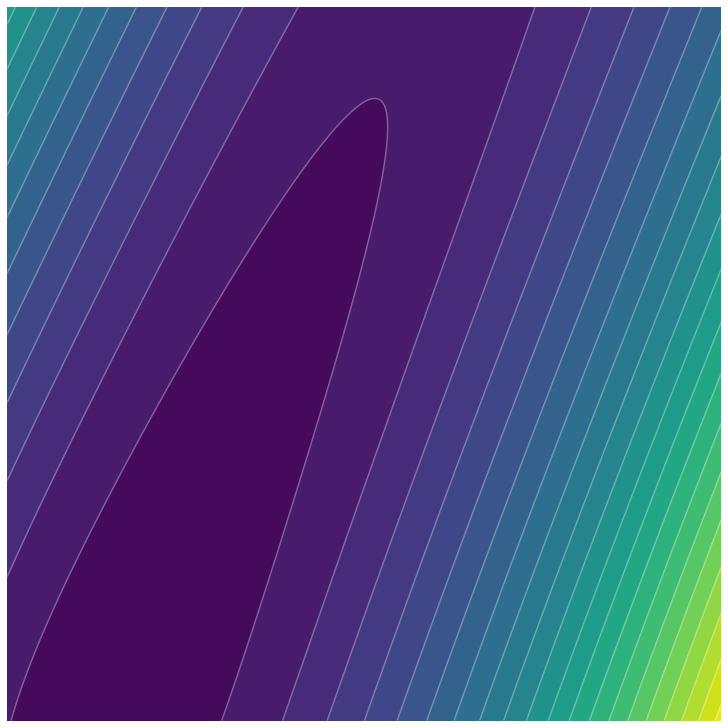

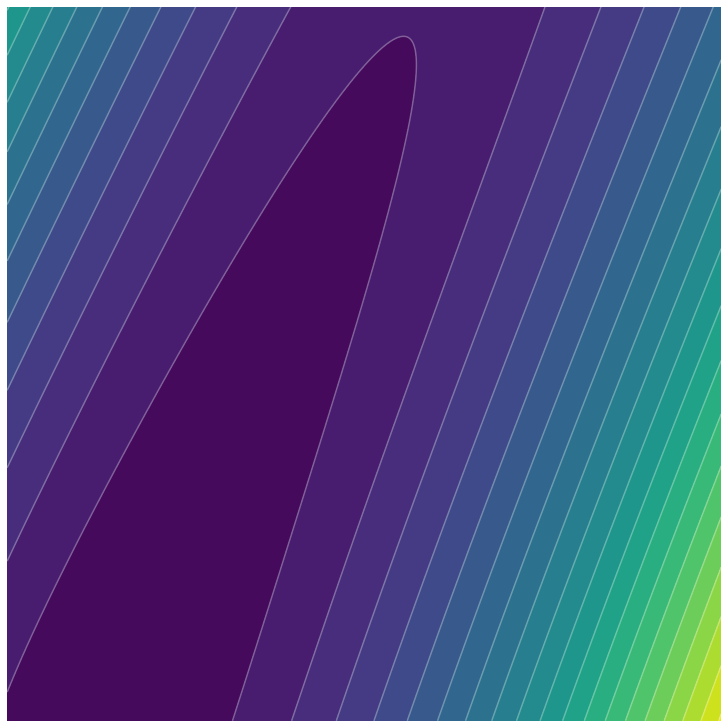

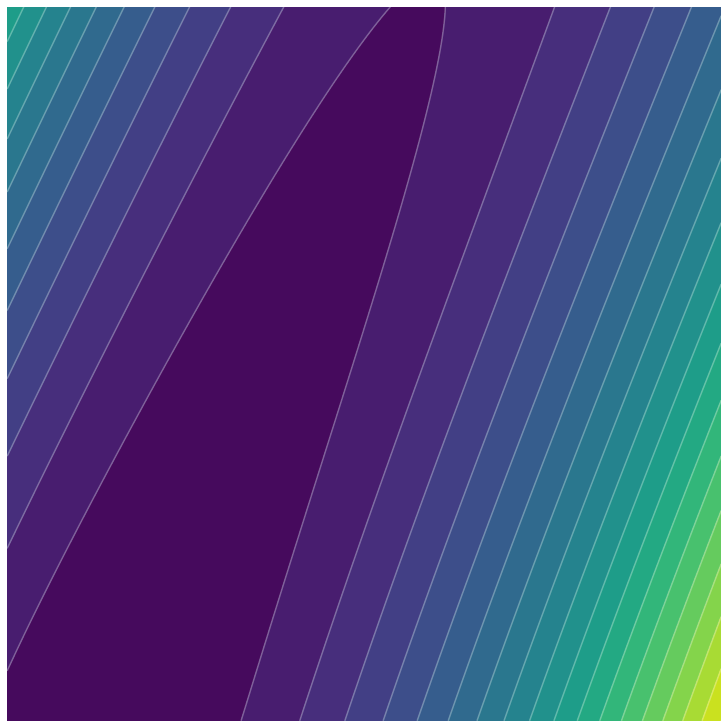

In [6]:
num_steps = 20
lr = 0.01

models = [Model(s) for s in lossSpaces]
optimizers = [torch.optim.SGD(model.parameters(), lr=lr) for model in models]

for i, (optimizer, model) in enumerate(zip(optimizers, models)):
    output = model()
    output = output.detach().numpy()
    save_viz(f'contours/model_{i}.svg', output)

for i in range(num_steps+1):
    values = []
    
    for optimizer, model in zip(optimizers, models):
        optimizer.zero_grad()
        output = model()
        output.sum().backward()
        optimizer.step()
        
        output = output.detach().numpy()
        
        values.append(output)
        
    
    values = np.sum(np.stack(values, axis=0), axis=0)
    
    save_viz(f'contours/accumulated_{i:02}.svg', values)